# Transformers seminar

This notebook is a supplementary material for the seminar on visual transformers (UT-ITC, 29 Oct 2022). It mainly discusses a Google paper about applying transformers from natural language processing to computer vision problems with minimal modifications.

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.
https://doi.org/10.48550/arxiv.2010.11929

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

#### Load dataset

We will play with simple MNIST dataset here as the purpose of this notebook is just to demonstrate how ViT works.

In [3]:
# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# extract dataset and image sizes
dataset_size, image_height, image_width = x_train.shape

# extract the number of classes
n_classes = len(np.unique(y_train))

# reshape the images so they have the channel dimension
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

# normalise the inputs
x_train = x_train / 255
x_test = x_test / 255

# one-hot encoding of the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# divide `x_train` and `y_train` into train and val subsets
val_ratio = 0.2
val_samples = int(val_ratio * dataset_size)
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
x_train, y_train = x_train[val_samples:], y_train[val_samples:]

Let's choose one random sample and use it later to show how it is transformed at different stages of ViT.

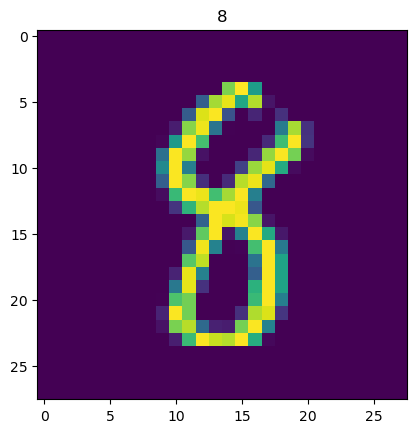

In [5]:
sample_idx = np.random.choice(len(x_train))
sample = x_train[sample_idx]
sample_label = y_train[sample_idx]

plt.title(np.argmax(sample_label))
plt.imshow(sample, vmin=0.0, vmax=1.0)
plt.show()

#### Patch extraction and embedding

First, we implement a layer for patch extraction. To do it there is a nice `tensorflow` function called `extract_patches`.

<img src="figures/vit_patch_embedding.png" width=480 />

In [6]:
class PatchExtraction(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtraction, self).__init__()
        self.patch_size = patch_size
        
    def call(self, inputs):
        # make patches
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME"
        )
        # flatten tensor from two-dimensional grid of patches to one-dimensional
        batch_size = tf.shape(inputs)[0]
        patches_count, depth = tf.shape(patches)[1] * tf.shape(patches)[2], tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, patches_count, depth])
        return patches

Now we can make a one-image batch from the sample image and apply this layer to it.

In [8]:
# Make batch
batch = tf.convert_to_tensor(sample)
batch = tf.expand_dims(batch, axis=0)
batch.shape

TensorShape([1, 28, 28, 1])

In [9]:
# create a layer and apply it to the batch
patch_size = 4
patches = PatchExtraction(patch_size)(batch)
patches.shape

TensorShape([1, 49, 16])

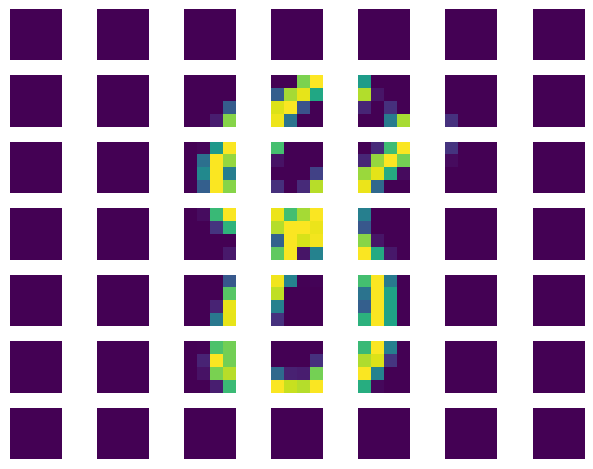

In [10]:
# convert to numpy
patches_np = patches[0].numpy()

# reshape (as pixels are flattened within patches)
patches_np = np.reshape(patches_np, (-1, patch_size, patch_size))

# and visualize
for patch_idx, patch in enumerate(patches_np):
    plt.subplot(image_height // patch_size, image_width // patch_size, patch_idx + 1)
    plt.imshow(patch, vmin=0.0, vmax=1.0)
    plt.axis("off")
plt.tight_layout()
plt.show()

Now we can implement patch embedding, which is a simple linear projection of the patches. Here, we decided to implement it as a separate layer that wraps a `Dense` layer to make the model's final code more readable and give you a more straightforward setup for modifications. However, in this situation, it was completely unnecessary. 

In [11]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_size):
        super(PatchEmbedding, self).__init__()
        self.projection = tf.keras.layers.Dense(embedding_size)
        
    def call(self, inputs):
        embedded_patches = self.projection(inputs)
        return embedded_patches

Let's proceed further and embed our patches obtained previously.

In [13]:
embedding_size = 32
embedded_patches = PatchEmbedding(embedding_size)(patches)
embedded_patches.shape

TensorShape([1, 49, 32])

Pay attention to how the tensor shapes changed so far:
1. Input image [28, 28, 1]
2. 4x4 patches [49, 16] = [(28/4)\*(28/4), 4*4]
3. Embedding (linear projection) [49, 32]

#### Class token

Now we will add an 'artificial' **learnable** token to the embedding that will represent the output class. It has the same size as an embedded patch and is processed later in the same way as other patches.

<img src="figures/vit_class_token.png" width=480 />

In [14]:
class AddClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super(AddClassToken, self).__init__()
        
    # note the use of the `build` method
    # it is useful to define weights/sublayers that are dependent on the input shape
    def build(self, input_shape):
        self.class_token = self.add_weight(
            name="class_token",
            shape=(input_shape[-1],),
            initializer="random_normal",
            trainable=True
        )
        
    def call(self, inputs):
        patches_with_class_token = tf.map_fn(
            lambda x: tf.concat((x, [self.class_token]), axis=0),
            inputs
        )
        return patches_with_class_token

As usual, let's apply this layer to the sample patches.

In [15]:
patches_with_class_token = AddClassToken()(embedded_patches)
patches_with_class_token.shape

TensorShape([1, 50, 32])

We can see now that there is a new 'patch' (50 vs 49), we can have a closer look at what is inside.

In [16]:
patches_with_class_token[0, -1, :]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0.07849021, -0.06710202, -0.00221198, -0.04001115,  0.03352876,
       -0.00968865, -0.00481853,  0.04909171, -0.03814843, -0.02115183,
       -0.05032863,  0.04577621, -0.04900284, -0.0309188 , -0.05680526,
        0.00502711,  0.13155311, -0.05899636,  0.0195624 , -0.0625842 ,
       -0.10022149, -0.00323665,  0.06680379,  0.01727597,  0.08662037,
        0.09005643,  0.02771654,  0.03572049,  0.05492475, -0.0523171 ,
        0.01757847, -0.07025711], dtype=float32)>

As expected, something random. :)

#### Positional embedding

Transformers heavily rely on self-attention, which is a global operator and, at the same time, do not differentiate how spatially its inputs are related. Therefore, we have to implement something that encodes the location of the patches. In ViT, the authors propose to add **learnable** vectors to the embedded patches (and hope that they manage to learn the spatial dependencies, in the paper they managed).

<img src="figures/vit_positional_encoding.png" width=480 />

Let's implement exactly the same idea!

In [17]:
class AddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self):
        super(AddPositionalEmbedding, self).__init__()
        
    def build(self, input_shape):
        self.positional_embedding = self.add_weight(
            name="positional_embedding",
            shape=input_shape[1:],
            initializer="random_normal",
            trainable=True
        )
        
    def call(self, inputs):
        return inputs + self.positional_embedding

And we can check again if the implementation is correct.

In [18]:
positionally_embedded_patches = AddPositionalEmbedding()(patches_with_class_token)
positionally_embedded_patches.shape

TensorShape([1, 50, 32])

**However**, this naive approach is not appropriate when you are working with images of different sizes (and, thus, having different numbers of patches per image). One of the workarounds, in this case, is to interpolate positional embeddings, which is not implemented here.

#### Transformer block

Following the paper, we can easily implement the transformer block described there. Happily, `tf.keras` has all the required operations, we just need to combine them in the right order.

<img src="figures/vit_encoder.png" width=480 />

In [66]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_size, mlp_size, n_heads, dropout):
        super(TransformerBlock, self).__init__()
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.mhsa = tf.keras.layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=embedding_size // n_heads
        )
        self.add = tf.keras.layers.Add()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.dense1 = tf.keras.layers.Dense(mlp_size, activation=tf.nn.gelu)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.dense2 = tf.keras.layers.Dense(embedding_size, activation=tf.nn.gelu)
        
    def call(self, inputs):
        # MHSA branch
        x1 = self.norm1(inputs)
        x1 = self.mhsa(x1, x1)
        # residual connection 1
        x2 = self.add([inputs, x1])
        # MLP branch
        x3 = self.norm2(x2)
        x3 = self.dense1(x3)
        x3 = self.dropout(x3)
        x3 = self.dense2(x3)
        x3 = self.dropout(x3)
        # residual connection 2
        outputs = self.add([x2, x3])
        return outputs

Run it to check on obvious bugs.

In [22]:
transformer_block_output = TransformerBlock(32, 64, 4, 0.1)(positionally_embedded_patches)
transformer_block_output.shape

TensorShape([1, 50, 32])

#### Extract class representation

In ViT, the class of the whole image is represented by one token introduced in the very beginning (of course, there are alternatives, in the paper they consider global average pooling as well). We need to extract this token to classify further.

In [23]:
class ExtractClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super(ExtractClassToken, self).__init__()
        
    def call(self, inputs):
        return inputs[:, -1, :] # all images, last patch, all features

Traditionally, we are checking how our sample image is transformed.

In [24]:
class_token = ExtractClassToken()(transformer_block_output)
class_token.shape

TensorShape([1, 32])

#### Classification head

As we are considering a classification problem, we would like to add a classification head to the model. A regular MLP is used in ViT, which is very straightforward.

<img src="figures/vit_classifier.png" width=480 />

In [25]:
class MLP(tf.keras.layers.Layer):
    def __init__(self, mlp_size, n_classes, dropout):
        super(MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(mlp_size, activation=tf.keras.activations.tanh)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.dense2 = tf.keras.layers.Dense(n_classes, activation=tf.keras.activations.softmax)
        
    def call(self, inputs):
        hidden = self.dense1(inputs)
        hidden = self.dropout(hidden)
        outputs = self.dense2(hidden)
        return outputs

In [26]:
classified = MLP(32, 10, 0.1)(class_token)
classified

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11216382, 0.07497188, 0.02458979, 0.0657139 , 0.09987289,
        0.08390631, 0.18306476, 0.08205833, 0.10313005, 0.17052825]],
      dtype=float32)>

#### Assembling everything together

Fine, everything is prepared to build a ViT model.

<img src="figures/vit.png" width=480 />

In [67]:
class ViT(tf.keras.models.Model):
    def __init__(
        self, 
        n_classes,
        patch_size=16, 
        embedding_size=768, 
        mlp_size=3072,
        n_blocks=12, 
        n_heads=12, 
        dropout=0.1, 
        name="ViT",
        **kwargs
    ):
        super(ViT, self).__init__(name=name, **kwargs)
        self.patch_extraction = PatchExtraction(patch_size)
        self.patch_embedding = PatchEmbedding(embedding_size)
        self.add_class_token = AddClassToken()
        self.add_positional_embedding = AddPositionalEmbedding()
        self.transformer_blocks = [
            TransformerBlock(embedding_size, mlp_size, n_heads, dropout)
            for _ in range(n_blocks)
        ]
        self.extract_class_token = ExtractClassToken()
        self.mlp = MLP(mlp_size, n_classes, dropout)
        
    def call(self, inputs):
        patches = self.patch_extraction(inputs)
        patches = self.patch_embedding(patches)
        patches = self.add_class_token(patches)
        patches = self.add_positional_embedding(patches)
        for block in self.transformer_blocks:
            patches = block(patches)
        class_token = self.extract_class_token(patches)
        outputs = self.mlp(class_token)
        return outputs

Now we can create a model and do some final checks.

In [28]:
vit_b16 = ViT(n_classes=1000)
vit_b16.build(input_shape=(8, 512, 512, 1))
vit_b16.summary()

Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_extraction_1 (PatchEx  multiple                 0         
 traction)                                                       
                                                                 
 patch_embedding_2 (PatchEmb  multiple                 197376    
 edding)                                                         
                                                                 
 add_class_token_1 (AddClass  multiple                 768       
 Token)                                                          
                                                                 
 add_positional_embedding_1   multiple                 787200    
 (AddPositionalEmbedding)                                        
                                                                 
 transformer_block_2 (Transf  multiple                 7087872 

This model is ViT-B/16 as they call it in the paper. We can now compare the number of parameters that we got with the number of parameters reported by the authors. If they match, we are on the right track. So, excluding the classification head and working with 512x512 images, we have got $91\,475\,176 - 5\,435\,368 = 86\,039\,808$ parameters. 

The authors report 86M parameters, however, it is not very clear if it is for 512x512 images and whether they exclude the classification head. Anyway, the number is really close, therefore, we expect that our implementation is also correct. 

In [29]:
del vit_b16

#### Training the model and evaluating it

First, let's define another variant of ViT that is not too complicated for MNIST, we call it `vit-toy`.

In [68]:
vit_toy = ViT(
    n_classes=n_classes,
    patch_size=4,
    embedding_size=64,
    mlp_size=128,
    n_blocks=6,
    n_heads=8,
    dropout=0.1,
    name="ViT-Toy"
)

batch_size = 512
vit_toy.build(input_shape=(batch_size, image_height, image_width, 1))
vit_toy.summary()

Model: "ViT-Toy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_extraction_7 (PatchEx  multiple                 0         
 traction)                                                       
                                                                 
 patch_embedding_8 (PatchEmb  multiple                 1088      
 edding)                                                         
                                                                 
 add_class_token_7 (AddClass  multiple                 64        
 Token)                                                          
                                                                 
 add_positional_embedding_7   multiple                 3200      
 (AddPositionalEmbedding)                                        
                                                                 
 transformer_block_50 (Trans  multiple                 3347

Compile it and fit it.

In [51]:
vit_toy.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # note that the use of AdamW is a more common practice when training transformers
    # however, we could not get good results with it for vit-toy and MNIST
    #optimizer=tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [52]:
training_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "vit_toy.h5", monitor="val_loss", save_best_only=True, save_weights_only=True
    ),
    tf.keras.callbacks.CSVLogger("vit_toy.csv"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=21, verbose=1, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1
    )
]

In [53]:
max_epochs = 2000
history = vit_toy.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(x_val, y_val),
    callbacks=training_callbacks
)

Epoch 1/2000
94/94 [==============================] - 22s 183ms/step - loss: 1.3729 - categorical_accuracy: 0.4960 - val_loss: 0.5704 - val_categorical_accuracy: 0.8098 - lr: 0.0010
Epoch 2/2000
94/94 [==============================] - 16s 173ms/step - loss: 0.4920 - categorical_accuracy: 0.8376 - val_loss: 0.3311 - val_categorical_accuracy: 0.8962 - lr: 0.0010
Epoch 3/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.3306 - categorical_accuracy: 0.8944 - val_loss: 0.2387 - val_categorical_accuracy: 0.9262 - lr: 0.0010
Epoch 4/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.2446 - categorical_accuracy: 0.9227 - val_loss: 0.2406 - val_categorical_accuracy: 0.9257 - lr: 0.0010
Epoch 5/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.2018 - categorical_accuracy: 0.9361 - val_loss: 0.1841 - val_categorical_accuracy: 0.9423 - lr: 0.0010
Epoch 6/2000
94/94 [==============================] - 16s 173ms/step - loss: 0.1820 - cate

Epoch 45/2000
94/94 [==============================] - 16s 171ms/step - loss: 0.0038 - categorical_accuracy: 0.9989 - val_loss: 0.0771 - val_categorical_accuracy: 0.9816 - lr: 1.0000e-04
Epoch 46/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.0039 - categorical_accuracy: 0.9989 - val_loss: 0.0767 - val_categorical_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 47/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.0031 - categorical_accuracy: 0.9993 - val_loss: 0.0754 - val_categorical_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 48/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.0031 - categorical_accuracy: 0.9993 - val_loss: 0.0757 - val_categorical_accuracy: 0.9827 - lr: 1.0000e-04
Epoch 49/2000
94/94 [==============================] - 16s 172ms/step - loss: 0.0025 - categorical_accuracy: 0.9997 - val_loss: 0.0770 - val_categorical_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 50/2000
94/94 [==============================] - 16s 171ms/

And evaluate it on the test set.

In [54]:
vit_toy.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0655 - categorical_accuracy: 0.9847


[0.06549768894910812, 0.9847000241279602]

Not the state-of-the-art but still impressive.